# Object Detection and Tracking with YOLOv3 and SORT

Ομάδα 11: 

Αργυρού Γεωργία 03119046

Μαγγελάκη Βαρβάρα-Κωνσταντίνα

Σημείωση: Λόγω του τεράστιου μεγέθους του αρχείου εχουμε αφαιρέσει τις εκφωνήσεις και τις εκτελέσεις με τα στιγμιότυπα του βίντεο. Παρακάτω παραθέτουμε και το link στο drive που περιέχει το ολοκληρωμένο αρχείο: 

https://drive.google.com/file/d/1xuQrB0ZduN8jzJmnu7uUrpaCrqGDu4rg/view?usp=sharing

In [2]:
import sys
!{sys.executable} -m pip install torch==1.11.0 torchvision==0.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.1 requi

In [3]:
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pillow
!{sys.executable} -m pip install filterpy==1.4.5
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install lap==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=e3b4abf53b5d64063bfbc8a10bc07a8c51e896704f0b1421d0244173c1aa307f
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.4 MB/s eta 0:00:00
  Preparing me

Mount to google drive.
Το κάνουμε αυτό για έχουμε πρόσβαση στα python modules που χρειαζόμαστε.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Για να μπορέσετε να έχετε πρόσβαση σε όλα τα αρχεία του φακέλου Lab_motion_tracking_exercise θα πρέπει πριν τρέξετε το παρακάτω κελί να πατε στο drive του εργαστηρίου, να κάνετε δεξί κλικ στο Lab_motion_tracking_exercise, να πατήσετε Add a shortcut to drive και μετά να πατήσετε My Drive.

In [5]:
import sys
import os 
sys.path.insert(0,'/content/drive/My Drive/Lab_motion_tracking_exercise') 
print(os.listdir('/content/drive/My Drive/Lab_motion_tracking_exercise')) # Έλεγχος ότι έχουμε όλα τα απαραίτητα αρχεία

['config', 'images', 'utils', 'models.py', 'road_trafifc.mp4', 'sort.py', '__pycache__', 'Object_Detection_and_Tracking.ipynb']


Φορτώνουμε τις απαραίτητες βιβλιοθήκες

In [6]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [7]:
import os
print(os.getcwd())

/content


### 1. Θεωρητικό μέρος

Ερώτημα 1

1. Ένα bounding box αποτελεί την περιοχή ενδιαφέροντος του υποψήφιου αντικειμένου. Ο αλγόριθμος YOLO (You Only Look Once) έχει ως στόχο να προβλέψει bounding boxes κάθε αντικειμένου μαζί με την πιθανότητα της κλάσης στην οποία ανήκει το αντικείμενο. Το μοντέλο χωρίζει κάθε εικόνα η οποία εισάγεται σε ένα πλέγμα SxS κελιών. Κάθε κελί προβλέπει B bounding boxes και C πιθανότητες κλάσης των αντικειμένων που πέφτουν στο κέντρο των κελιών του πλέγματος. Κάθε bounding box μπορεί να ειδικεύεται στην εύρεση ενός συγκεκριμένου είδους αντικειμένου. Tα bounding boxes Β είναι συνδεδεμένα με έναν αριθμό anchors που χρησιμοποιούνται. Κάθε bounding box έχει 5 + C γνωρίσματα. Τα 5 γνωρίσματα αποτελόυνται από: Συντεταγμένες κέντρου (bx, by), ύψος (bh), πλάτος (bw) και πιθανότητα επιτυχίας (pc). C είναι ο αριθμός των κλάσεων

2. Στην ανίχνευση αντικειμένων προέκυψε πρόβλημα όταν τα αντικείμενα προς εύρεση δεν ήταν τετράγωνου σχήματος. Αυτά τα αντικείμενα μπορούσαν να είναι οποιουδήποτε τύπου, κυρίως ορθογώνιου τύπου. Τότε ήταν η στιγμή που άρχισαν να χρησιμοποιούνται τα anchor boxes. Τα anchor boxes είναι προσχεδιασμένα κουτιά που έχουν ένα σύνολο αναλογίας διαστάσεων. Οι αναλογίες διαστάσεων είναι ορισμένες πριν την εκμάθηση με την εκτέλεση K-means clustering σε όλο τό σύνολο των δεδομένων. K-means clustering στην ουσία αποτελεί την εύρεση του μέσου όρου των δεδομένων, δηλαδή του κεντροειδούς, στο αντίστοιχο σύμπλεγμα. Τα anchor boxes "αγκυροβολούν" στα κελιά του συμπλέγματος και μοιράζονται το ίδιο κεντροειδές.



Ερώτημα 2

Στην περίπτωση που εκτελέσουμε τον YOLO αλγόριθμο θεωρώντας ότι έχουμε δυο anchor boxes και 3 κλάσεις, τότε ο πίνακας εξόδου θα διαμορφωθεί ως εξής: Αρχικά θα έχουμε 3 κλάσεις, άρα c1, c2, c3. Έπειτα, κάθε anchor box θα αποτελείται από συντεταγμένες κέντρου (bx, by), ύψους (bh), πλάτους (bw) και πιθανότητα επιτυχίας (pc). Όμως έχουμε 2 anchor boxes, άρα ο πίνακας εξόδου θα έχει τη μορφή:

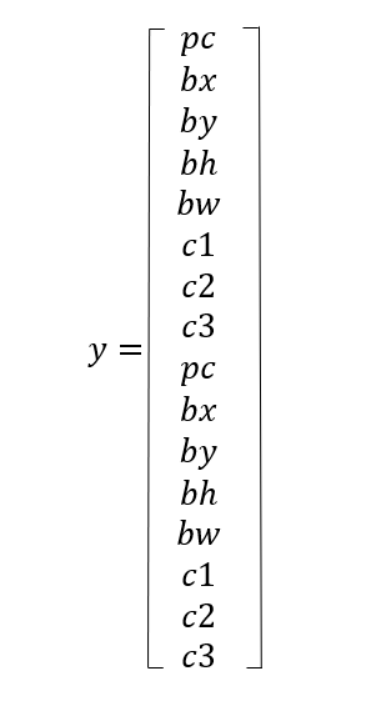

Ερώτημα 3

Υπάρχει πιθανότητα μετά από ένα πέρασμα της εικόνας εισόδου, η έξοδος να έχει πολλαπλά bounding boxes για το ίδιο αντικείμενο αφού το κεντροειδές είναι το ίδιο. Όμως χρειαζόμαστε ένα και το πιο κατάλληλο bounding box. Για αυτό το πρόβλημα μας είναι χρήσιμη η μέθοδος Non-Maximum Suppression. Πρακτικά φιλτράρει τα πολλαπλά bounding boxes. Μπορούμε να ορίσουμε ένα συγκεκριμένο κατώφλι το οποίο δρα σαν περιορισμός για την NMS μέθοδο. Το κατώφλι αυτό αγνοεί τα υπόλοιπα bounding boxes των οποίων η πιθανότητα επιτυχίας είναι μικρότερη της τιμής του κατωφλιού μας. Έτσι, φιλτράρονται τα bounding boxes, χωρίς όμως να έχει γίνει ολοκληρωτικό φιλτράρισμα. Εν συνεχεία, η μέθοδος ταξινομεί σε φθίνουσα σειρά τα bounding boxes και διαλέγει εκείνο με την υψηλότερη πιθανότητα επιτυχίας ως το πιο κατάλληλο για το αντικείμενο. Τέλος, βρίσκουμε όλα τα υπόλοιπα κουτιά με μεγάλο σημείο τομής με το κουτί με την μεγαλύτερη πιθανότητα επιτυχίας και διαγράφουμε κι αυτά. Έτσι, μέσω της μεθόδου αυτής εξάγεται το πιο κατάλληλο κουτί.

Ερώτημα 4

Στο τρίτο βήμα του αλγορίθμου SORT γίνεται matching των διάφορων αντικειμένων της εικόνας με τον Hungarian αλγόριθμο. Υπολογίζει το ελάχιστο κόστος της IoU απόστασης μεταξύ κάθε ανίχνευσης κι όλων των bounding boxes. Ένα παράδειγμα μετρικής της απόστασης των bounding boxes αποτελεί η παρακάτω εικόνα. Συγκρίνουμε το κόστος IoU του αριστερού κίτρινου bounding box με τα τρία κόκκινα bounding boxes (detections). Μεγαλύτερο IoU έχει το αριστερό κόκκινο bounding box. Τα άλλα δύο IoU είναι μηδενικά αφού η τομή τους με το αριστερό κίτρινο κουτί (prediction) είναι μηδενική.

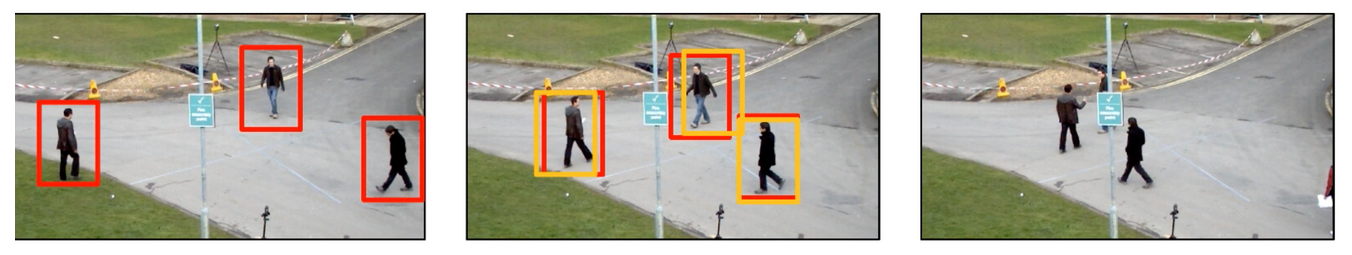

Ερώτημα 5



Η κεντρική ιδέα της μεθόδου tracking-by-detection είναι η εξής: Όταν υφίσταται ένα σύνολο ανιχνεύσεων για ένα πλήθος στιγμιοτύπων ενός βίντεο, τα οποία είναι ανεξάρτητα μεταξύ τους, το πρόβλημα είναι να βρεθούν οι αντιστοιχίες των ανιχνεύσεων με τα στιγμιότυπα και να υπολογιστεί η τροχιά τους. Αποτελεί μια κοινή προσέγγιση σε προβλήματα multi-object tracking. Object-tracking προβλήματα αποτελούν μια εφαρμογή βαθιάς μάθησης όπου το πρόγραμμα λαμβάνει ένα αρχικό σύνολο ανιχνεύσεων και αναπτύσσει μια μοναδική ταυτοποίηση για κάθε αρχική ανίχνευση. Εν συνεχεία, εντοπίζει τα ανιχνευμένα αντικείμενα όσο διαγράφουν την τροχιά τους στα στιγμιότυπα ενός βίντεο.

Συγκεκριμένα τα βήματα που πραγματοποιούνται κατά την μέθοδο Multi-Object Tracking κάνοντας χρήση του SORT αλγόριθμου είναι τα εξής:

  1. Τα αντίκειμενα του frame εντοπίζονται και καθορίζονται τα bounding boxes αυτών.
  2. Για το frame t + 1 αν εντοπίσαμε για αρκετό χρόνικό διάστημα τα συγκεκριμένα αντικείμενα χρησιμοποιούμε το motion model (Kalman filter) για να εξάγουμε τα predictions. Δηλαδή το πόσο κουνήθηκαν τα bounding boxes σε σχεση με το frame t, υποθέτοντας ότι η κίνηση θα είναι παρόμοια με τις προηγούμενες χρονικές στιγμές.



### 2. Αλλαγή των υπερπαραμέτρων του αλγορίθμου

In [8]:
config_path='./drive/My Drive/Lab_motion_tracking_exercise/config/yolov3.cfg'
weights_path='./drive/My Drive/Lab_motion_tracking_exercise/config/yolov3.weights' # Φορτώνουμε τα προ-εκπαιδευμένα στο COCO dataset βάρη του μοντέλου YOLOv3
class_path='./drive/My Drive/Lab_motion_tracking_exercise/config/coco.names'  #  φορτώνουμε τις μονο τις κλάσεις που θέλουμε να κάνουμε detection (ανθρώπους, αυτοκίνητα κλπ) 
#img_size=416
#conf_thres=0.8
#nms_thres=0.4

img_size=416
conf_thres=0.8 #Εδώ αλλάζουμε τις τιμές των υπερπαραμέτρων
nms_thres=0.9 # NMS threshold


# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [9]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.638785


<Figure size 640x480 with 0 Axes>

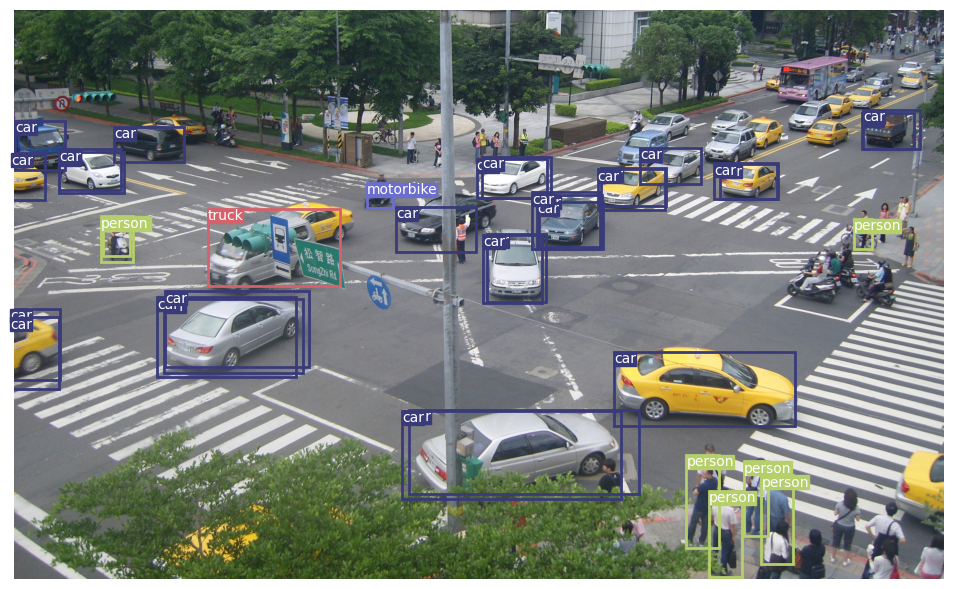

In [10]:
# load image and get detections
#print(os.getcwd())
img_path = "./drive/My Drive/Lab_motion_tracking_exercise/images/Intersection-Counts.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections.cpu():
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
#plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

### Εκτέλεση με τις αρχικές τιμές της εκφώνησης

In [ ]:
%pylab inline 
import cv2
from IPython.display import clear_output

videopath = './drive/My Drive/11.mp4'  # Εδώ θα αλλάξετε το path για να πάρετε το video που αντιστοιχεί στην ομάδα σας
                                                                      # Το video θα πρεπει αρχικά να το έχετε βάλει στο drive σας 
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 
frames = vid.get(cv2.CAP_PROP_FRAME_COUNT)
#while(True):
for ii in range(int(frames)):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        print("ii", ii)
        print(detections.shape)
        tracked_objects = mot_tracker.update(detections.cpu())
        print(tracked_objects.shape)

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    #clear_output(wait=True)

i) Μια μικρή τιμή του conf_thres (0.1 - 0.4), κρατώντας την τιμή για nms_trhes=0.4

In [ ]:
%pylab inline 
import cv2
from IPython.display import clear_output

videopath = './drive/My Drive/11.mp4'  # Εδώ θα αλλάξετε το path για να πάρετε το video που αντιστοιχεί στην ομάδα σας
                                                                      # Το video θα πρεπει αρχικά να το έχετε βάλει στο drive σας 
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 
frames = vid.get(cv2.CAP_PROP_FRAME_COUNT)
#while(True):
for ii in range(int(frames)):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        print("ii", ii)
        print(detections.shape)
        tracked_objects = mot_tracker.update(detections.cpu())
        print(tracked_objects.shape)

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    #clear_output(wait=True)

Για τα επόμενα ερωτήματα, θα τρέξουμε τον κώδικα για λιγότερες τιμές του ii ενδεικτικά 40, προκειμένου να εξοικονομήσουμε χρόνο και χώρο, χωρίς αυτό να επηρεάζει τα συμπεράσματά μας.

ii) Μια μεγάλη τιμή του conf_thres(0.6 - 0.9), κρατώντας την τιμή για nms_trhes=0.4

In [ ]:
%pylab inline 
import cv2
from IPython.display import clear_output

videopath = './drive/My Drive/11.mp4'  # Εδώ θα αλλάξετε το path για να πάρετε το video που αντιστοιχεί στην ομάδα σας
                                                                      # Το video θα πρεπει αρχικά να το έχετε βάλει στο drive σας 
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 
frames = vid.get(cv2.CAP_PROP_FRAME_COUNT)
#while(True):
for ii in range(40):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        print("ii", ii)
        print(detections.shape)
        tracked_objects = mot_tracker.update(detections.cpu())
        print(tracked_objects.shape)

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    #clear_output(wait=True)

iii) Μια μικρή τιμή του nms_thres (0.1 - 0.4), κρατώντας την τιμή για conf_trhes=0.8

In [ ]:
%pylab inline 
import cv2
from IPython.display import clear_output

videopath = './drive/My Drive/11.mp4'  # Εδώ θα αλλάξετε το path για να πάρετε το video που αντιστοιχεί στην ομάδα σας
                                                                      # Το video θα πρεπει αρχικά να το έχετε βάλει στο drive σας 
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 
frames = vid.get(cv2.CAP_PROP_FRAME_COUNT)
#while(True):
for ii in range(40):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        print("ii", ii)
        print(detections.shape)
        tracked_objects = mot_tracker.update(detections.cpu())
        print(tracked_objects.shape)

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    #clear_output(wait=True)

iv) Μια μεγάλη τιμή του nms_thres (0.6 - 0.9), κρατώνταςτην τιμή για conf_trhes=0.8

In [ ]:
%pylab inline 
import cv2
from IPython.display import clear_output

videopath = './drive/My Drive/11.mp4'  # Εδώ θα αλλάξετε το path για να πάρετε το video που αντιστοιχεί στην ομάδα σας
                                                                      # Το video θα πρεπει αρχικά να το έχετε βάλει στο drive σας 
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 
frames = vid.get(cv2.CAP_PROP_FRAME_COUNT)
#while(True):
for ii in range(40):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        print("ii", ii)
        print(detections.shape)
        tracked_objects = mot_tracker.update(detections.cpu())
        print(tracked_objects.shape)

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    #clear_output(wait=True)

Συμπεράσματα

Conf_thres: Παρατηρούμε ότι όσο μεγαλύτερο είναι το κατώφλι εμπιστοσύνης, τόσο λιγότερα είναι τα αντικείμενα που ανιχνεύονται, όπως άνθρωποι, ποδήλατα και αυτοκίνητα στο παράδειγμά μας. Αντίθετα, για μικρές τιμές του κατωφλίου, ο αλγόριθμος βρίσκεται σε θέση να εντοπίσει και να κατατάξει σε κλάσεις τα περισσότερα από τα αντικείμενα που βρίσκονται σε κάθε στιγμιότυπο του βίντεο.

Nms_thres: Παρατηρούμε ότι για μεγάλες τιμές του Non-Maximum Suppression threshold, αντικείμενα της κλάσης άτομα, αυτοκίνητα για παράδειγμα ανιχνεύνται από τον αλγόριθμο και δεύτερη φορά, σε αντίθεση με μικρές τιμές, για τις οποίες ανιχνεύονται ακριβώς μία φορά.

Συμπερασματικά, για να επιτύχουμε την καλύτερη δυνατή ανίχνευση αντικειμένων και ταυτόχρονα να αποφύγουμε την πολλαπλή ανίχνευση των ίδιων αντικειμένων, θα ήταν προτιμότερο να επιλέξουμε έναν συνδυασμό μικρών τιμών και των δυο κατωφλίων.